In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from tensorflow.keras.callbacks import Callback
from src import metrics as _metrics
import src.loss as loss
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates, PatchesHandlerEvidential

from src.Trainer import Trainer

In [3]:
'''
import src.patchesHandler as patchesHandler

if issubclass(type(dataset), MultipleDates):
	patchesHandler = patchesHandler.PatchesHandlerEvidential(
		dataset)
else:
	patchesHandler = patchesHandler.PatchesHandler()
'''

'\nimport src.patchesHandler as patchesHandler\n\nif issubclass(type(dataset), MultipleDates):\n\tpatchesHandler = patchesHandler.PatchesHandlerEvidential(\n\t\tdataset)\nelse:\n\tpatchesHandler = patchesHandler.PatchesHandler()\n'

In [4]:
training = True
save_probabilities = False
loadInference = False
addPastDeforestationInput = True

'''
if training == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if training == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
dates = [2018, 2019]
ic(dates)
dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)	
# dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]
# dataset = PA()
if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerEvidential(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = 1


if training == False:
	if type(dataset) == Para:
		exp = 2

	if type(dataset) == PADeforestationTime:
		# exp = 3 # uses past deforestation mask until 2020, which is a mistake. use it until 2018
		exp = 4 # uses past deforestation mask without dates.
		exp = 5 # uses past deforestation mask with dates. 38 epochs.
		exp = 5 # fixes mask.
		exp = 6 # uses past deforestation distance and past deforestation. didnt test it yet        
		exp = 8 # Uses fixed past deforestation distance and past deforestation. 98.9 mAP
		exp = 9 # dummy for coords. high mAP. 99.8.   
		exp = 10 # using fixed fixed past deforestation distance. mAP 90.7   
		exp = 12 # Multiple dates. using fixed fixed past deforestation distance. mAP reduced to 89.6
	if type(dataset) == PADistanceMap:
		exp = 7 # not so good result.
	if type(dataset) == PAMultipleDates:
		exp = 11 # Multiple dates. using fixed fixed past deforestation distance
		exp = 22
		exp = 50
		exp = 52
		# exp = 54
		exp = 56
		exp = 58
		# exp = 63
		# exp = 52
		# exp = 64
		# exp = 66
		exp = 66
		exp = 68
		
		# =============
		# exp = 72 # train 2015-2018
		# exp = 69 # train 2016-2018
		# exp = 70 # train 2017-2018
		
		# train 2018-2019. test 2018-2019
		# exp = 39 # old 
		exp = 76 # 88.4 mAP
		# exp = 71 # 89.5 mAP

		# =============
		
		### exp = 73
		# exp = 71
		# exp = 61

		exp = 77 # good?
		# exp = 78 # good but too short?

		exp = 90 # good result. label ok. f1 84.4 train 2018-2019
		exp = 92 # train 2017-2018
		exp = 93 # train 2016-2018
		exp = 94 # train 2015-2018
		
		exp = 96 # train 2018-2019
		exp = 97 # train 2017-2018
		exp = 98 # train 2016-2018
		exp = 99 # train 2015-2018

		exp = 103

		exp = 118


		# train 2017-2018
		exp = 139
	if type(dataset) == MTDeforestationTime:
		exp = 28
	if type(dataset) == MTMultipleDates:
		exp = 73 # train 2018-2019
		# exp = 74 # train 2016-2019
		# exp = 75 # train 2017-2019
		
		exp = 78 # 2019-2020

		# exp = 88 adds project past deforestation to label
		exp = 89 # ok label. so so result
		
		exp = 91 # ok label. Good result. 81.8 F1. train 2019-2020
		exp = 95 # train 2018-2019
		exp = 100 # train 2017-2019
		exp = 101 # train 2016-2019
		exp = 102 # train 2016-2019
		
		# train 2018-2019
		exp = 137
		
else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 141 # Evidential DL with error
	exp = 142
	

ic| dates: [2018, 2019]
ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [5]:
exp

142

In [6]:
figures_path = 'figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [7]:
# ic(type(dataset), exp, dataset.dates)


In [8]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [9]:
# np.save('label_not_independent.npy', label_mask)


In [10]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [11]:
label_mask.dtype

dtype('uint8')

In [12]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [13]:
label_mask.dtype

dtype('uint8')

In [14]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [15]:
np.unique(image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

(-0.5, 9199.5, 17729.5, -0.5)

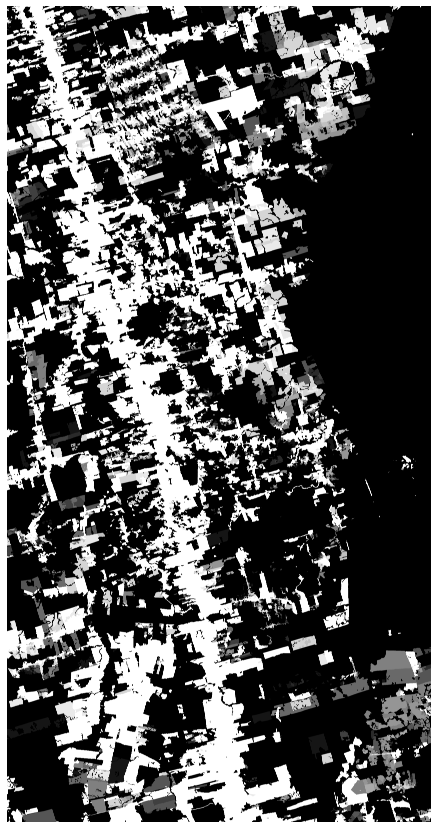

In [16]:


plt.figure(figsize=(15,15))
plt.imshow(image_stack[...,0], cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [17]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (17730, 9200, 21)
ic| channels: 21


21

In [18]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [19]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


ic| im_idx_row.shape: (17730, 9200, 1)
    im_idx_col.shape: (17730, 9200, 1)
ic| im_idx_row.dtype: dtype('uint16')
    im_idx_col.dtype: dtype('uint16')
ic| im_idx.shape: (17730, 9200, 2), im_idx.dtype: dtype('uint16')


In [20]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

ic| coords.shape: (464, 239, 1, 128, 128, 2)
    coords.dtype: dtype('uint16')
ic| coords.shape: (110896, 2), coords.dtype: dtype('uint16')
ic| coords_train.shape: (41812, 3), coords_val.shape: (10260, 3)


In [21]:
label_mask.shape

(17730, 9200, 1)

(-0.5, 9199.5, 17729.5, -0.5)

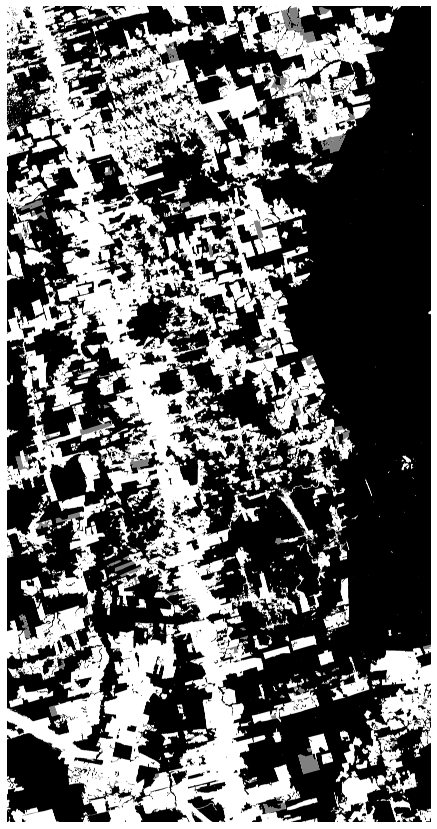

In [22]:

plt.figure(figsize=(15,15))
if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [23]:
np.unique(label_mask)

array([0, 1, 2], dtype=uint8)

In [24]:
if training == True:
    print(coords_train)

[[    0     0     0]
 [    0    38     0]
 [    0    76     0]
 ...
 [17594  8968     0]
 [17594  9006     0]
 [17594  9044     0]]


In [25]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


training samples:  (3753, 3) validation samples:  (1032, 3)


In [26]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [27]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [28]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [29]:
inputSnipShow = False

In [30]:
if training == True and inputSnipShow == True:
    idx = 2800
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [31]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [32]:
if training == True and inputSnipShow == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [33]:
if training == True and inputSnipShow == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [34]:
inputSnipShow = False
if training == True and inputSnipShow == True:

    idx = 400
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [35]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [36]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [37]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [38]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [39]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/exp142'

In [40]:
channels

21

In [41]:
image_stack.shape

(17730, 9200, 21)

In [42]:

# evidential
class_n = 3

def KL(alpha, K):
	beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
	S_alpha = tf.reduce_sum(alpha,axis=-1,keepdims=True)
	
	KL = tf.reduce_sum((alpha - beta)*(tf.math.digamma(alpha)-tf.math.digamma(S_alpha)),axis=-1,keepdims=True) + \
		 tf.math.lgamma(S_alpha) - tf.reduce_sum(tf.math.lgamma(alpha),axis=-1,keepdims=True) + \
		 tf.reduce_sum(tf.math.lgamma(beta),axis=-1,keepdims=True) - tf.math.lgamma(tf.reduce_sum(beta,axis=-1,keepdims=True))
	return KL

# KL_reg_monitor = K.variable(0.0)

def loss_eq5(p, alpha, K, global_step, annealing_step):
	S = tf.reduce_sum(alpha, axis=-1, keepdims=True)
	loglikelihood = tf.reduce_sum((p-(alpha/S))**2, axis=-1, keepdims=True) + tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=-1, keepdims=True)
	#global_step = tf.compat.v1.train.get_global_step
	KL_reg =  tf.minimum(1.0, tf.cast(global_step/annealing_step, tf.float32)) * KL((alpha - 1)*(1-p) + 1 , K)
	# tf.keras.backend.set_value(KL_reg_monitor, tf.keras.backend.get_value(KL_reg))
	return loglikelihood + KL_reg
'''
class EpochTracker(Callback):
	def __init__(self):
		super(EpochTracker, self).__init__()
		self.epoch_n = 0 

	def on_epoch_begin(self, epoch, logs={}):
		#if epoch%20 == 0:   
		K.set_value(self.epoch_n, epoch)
		print("Setting alpha to =", str(epoch))
epochTracker = EpochTracker()
'''


global_step = K.variable(0.0)
annealing_step  = 10*117
annealing_step  = 10*375

annealing_step  = 10*375/2

# annealing_step  = 10*375/4

# def loss_evidential(weights):
def loss_evidential():

	# init the tensor with current epoch, to be updated during training, and define var in scope
	# self.global_step = K.variable(0.0)
	# global_step = self.global_step  
	def loss(y_true, y_pred):  
		evidence = tf.nn.relu(y_pred)

		alpha = evidence + 1
		u = class_n / tf.reduce_sum(alpha, axis= -1, keepdims=True)

		print("alpha", alpha)
		print("u", u)
		prob = alpha / tf.reduce_sum(alpha, axis = -1, keepdims=True) 

		Y = y_true
		# loss = loss_eq5(Y, alpha, class_n, global_step, 30) # 10*34
		# loss = loss_eq5(Y, alpha, class_n, global_step, 40) # 10*34
		loss = loss_eq5(Y, alpha, class_n, global_step, annealing_step) # 10*3753/32

		#    loss = loss_eq5(Y, alpha, class_n, global_step, 15) # 10*34
		#    loss = loss_eq5(Y, alpha, class_n, global_step, 5) # 10*34
		#    loss = loss_eq5(Y, alpha, class_n, global_step, 60) # 10*34
		# loss = loss * weights
		loss = tf.reduce_mean(loss)
		return loss
	return loss

In [43]:

class GetCurrentEpoch(Callback):
    """get the current epoch to pass it within the loss function.
    # Arguments
        global_step: The tensor withholding the current epoch on_epoch_begin
    """

    def __init__(self, global_step):
        super().__init__()
        self.global_step = global_step
        # self.KL_reg_monitor = KL_reg_monitor
        self.epoch = 0
    def on_batch_begin(self, step, logs=None):
        new_step = step + self.epoch * step
        # Set new value
        K.set_value(self.global_step, new_step)

    def on_epoch_begin(self, epoch, logs=None):
        # K.set_value(self.epoch, epoch)
        self.epoch = epoch
        print("self.global_step", K.get_value(self.global_step))
        # print("KL_reg_monitor", K.get_value(self.KL_reg_monitor))

### Evidential metrics

In [44]:

import tensorflow.keras.backend as K

def loss_eq5_metric(p, alpha, K, global_step, annealing_step):
    S = tf.reduce_sum(alpha, axis=-1, keepdims=True)
    loglikelihood = tf.reduce_sum((p-(alpha/S))**2, axis=-1, keepdims=True) + tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=-1, keepdims=True)
    #global_step = tf.compat.v1.train.get_global_step
    KL_reg =  tf.minimum(1.0, tf.cast(global_step/annealing_step, tf.float32)) * KL((alpha - 1)*(1-p) + 1 , K)
    # tf.keras.backend.set_value(KL_reg_monitor, tf.keras.backend.get_value(KL_reg))
    print("K.int_shape(KL_reg)", KL_reg)
    return loglikelihood + KL_reg, loglikelihood, KL_reg

def loss_eq4_metric(p, alpha, K, global_step, annealing_step):
    loglikelihood = tf.reduce_mean(tf.reduce_sum(p * (tf.math.digamma(tf.reduce_sum(alpha, axis=1, keepdims=True)) - tf.math.digamma(alpha)), 1, keepdims=True))
    KL_reg =  tf.minimum(1.0, tf.cast(global_step/annealing_step, tf.float32)) * KL((alpha - 1)*(1-p) + 1 , K)
    return loglikelihood + KL_reg, loglikelihood, KL_reg

def loss_eq3_metric(p, alpha, K, global_step, annealing_step):
    loglikelihood = tf.reduce_mean(tf.reduce_sum(p * (tf.math.log(tf.reduce_sum(alpha, axis=1, keepdims=True)) - tf.math.log(alpha)), 1, keepdims=True))
    KL_reg =  tf.minimum(1.0, tf.cast(global_step/annealing_step, tf.float32)) * KL((alpha - 1)*(1-p) + 1 , K)
    return loglikelihood + KL_reg, loglikelihood, KL_reg

def evidence_get(y_pred):
    evidence = tf.nn.relu(y_pred)

    alpha = evidence + 1
    u = class_n / tf.reduce_sum(alpha, axis= -1, keepdims=True)

    print("alpha", alpha)
    print("u", u)
    prob = alpha / tf.reduce_sum(alpha, axis = -1, keepdims=True) 

    return alpha, u

loss_metric = loss_eq5_metric
def KL_term(y_true, y_pred):
    alpha, u = evidence_get(y_pred)
    Y = y_true

    _, _, KL_reg = loss_metric(Y, alpha, class_n, global_step, annealing_step)

    KL_reg = tf.reduce_mean(KL_reg)
    return KL_reg

def loglikelihood_term(y_true, y_pred):
    alpha, u = evidence_get(y_pred)
    Y = y_true

    _, loglikelihood, _ = loss_metric(Y, alpha, class_n, global_step, annealing_step)

    loglikelihood = tf.reduce_mean(loglikelihood)
    return loglikelihood

def acc(y_true, y_pred):
    logits = y_pred
    Y = y_true
    evidence = tf.nn.relu(y_pred)
    match = tf.reshape(tf.cast(tf.equal(tf.argmax(logits, -1), tf.argmax(Y, -1)), tf.float32),(-1,1))
    acc = tf.reduce_mean(match)
    return acc

def evidential_success(y_true, y_pred):
    logits = y_pred
    Y = y_true
    evidence = tf.nn.relu(y_pred)
    match = tf.reshape(tf.cast(tf.equal(tf.argmax(logits, -1), tf.argmax(Y, -1)), tf.float32),(-1,1))
    mean_ev_succ = tf.reduce_sum(tf.reshape(tf.reduce_sum(evidence,-1, keepdims=True), (-1,1)) * match) / tf.reduce_sum(match+1e-20)
    return mean_ev_succ
def evidential_fail(y_true, y_pred):
    logits = y_pred
    Y = y_true
    evidence = tf.nn.relu(y_pred)
    match = tf.reshape(tf.cast(tf.equal(tf.argmax(logits, -1), tf.argmax(Y, -1)), tf.float32),(-1,1))
    mean_ev_fail = tf.reduce_sum(tf.reshape(tf.reduce_sum(evidence,-1, keepdims=True), (-1,1)) * (1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) 
    return mean_ev_fail

def annealing_coef(y_true, y_pred):
    return tf.minimum(1.0, tf.cast(global_step/annealing_step, tf.float32))

def global_step_get(y_true, y_pred):
    return tf.cast(global_step, tf.float32)

def annealing_step_get(y_true, y_pred):
    return tf.cast(annealing_step, tf.float32)

In [45]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
#         loss = loss.weighted_categorical_crossentropy(weights)
        loss = loss_evidential()

        input_shape = (rows, cols, channels)
        model = build_resunet(input_shape, nb_filters, number_class, last_activation=None)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy', KL_term, loglikelihood_term, 
            evidential_success, evidential_fail, acc, annealing_coef, global_step_get, annealing_step_get])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        get_global_step = GetCurrentEpoch(global_step=global_step)
        
        callbacks_list = [earlystop, checkpoint, get_global_step]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

time:  0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_enc_net (InputLayer)      [(None, 128, 128, 21 0                                            
__________________________________________________________________________________________________
res1_net1 (Conv2D)              (None, 128, 128, 16) 3040        input_enc_net[0][0]              
__________________________________________________________________________________________________
drop_net1 (Dropout)             (None, 128, 128, 16) 0           res1_net1[0][0]                  
__________________________________________________________________________________________________
res2_net1 (Conv2D)              (None, 128, 128, 16) 2320        drop_net1[0][0]                  
_____________________________________________________________________________________

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
self.global_step 0.0
alpha Tensor("loss/add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("loss/truediv:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(KL_reg) Tensor("mul_6:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add_7:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv_5:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(KL_reg) Tensor("mul_12:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("loss/add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("loss/truediv:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(KL_reg) Tensor("mul_6:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add_7:0", shape=(None, 128, 128, 3), dtype=float

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
self.global_step 350.0
351/351 [==============================] - 32s 90ms/step - loss: 0.1465 - accuracy: 0.9255 - KL_term: 0.0186 - loglikelihood_term: 0.1280 - evidential_success: 71.0024 - evidential_fail: 7.6993 - acc: 0.9255 - annealing_coef: 0.1867 - global_step_get: 350.0000 - annealing_step_get: 1875.0000 - val_loss: 0.1646 - val_accuracy: 0.9255 - val_KL_term: 0.0308 - val_loglikelihood_term: 0.1323 - val_evidential_success: 49.1014 - val_evidential_fail: 4.0420 - val_acc: 0.9261 - val_annealing_coef: 0.3733 - val_global_step_get: 700.0000 - val_annealing_step_get: 1875.0000

Epoch 00002: val_loss did not improve from 0.15932
Epoch 3/100
self.global_step 700.0
351/351 [==============================] - 32s 90ms/step - loss: 0.1399 - accuracy: 0.9326 - KL_term: 0.0211 - loglikelihood_term: 0.1187 - evidential_success: 81.9331 - evidential_fail: 6.6272 - acc: 0.9326 - annealing_coef: 0.2800 - global_step_get: 525.0000 - annealing_step_get: 1875.0000 - val_loss: 0.16

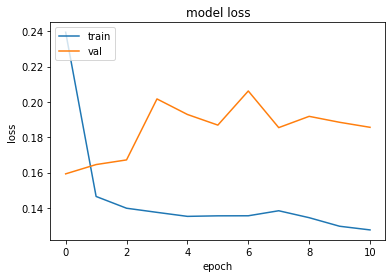

In [46]:
if training == True:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('loss_history.png')

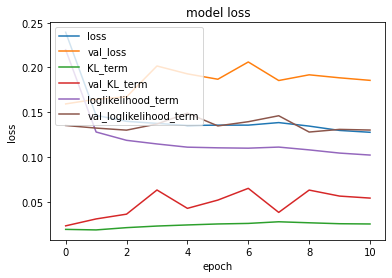

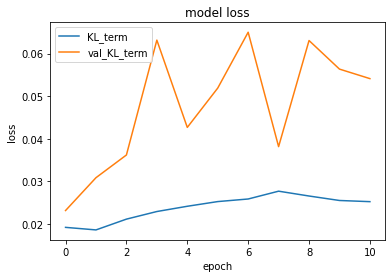

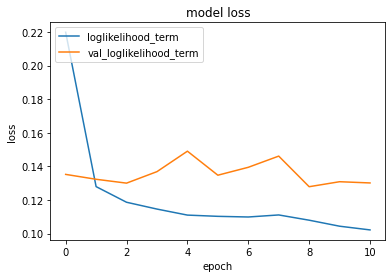

In [47]:
l = ['loss', 'val_loss', 'KL_term', 'val_KL_term', 'loglikelihood_term', 'val_loglikelihood_term']


plt.figure(2)
plt.plot(history.history[l[0]])
plt.plot(history.history[l[1]])
plt.plot(history.history[l[2]])
plt.plot(history.history[l[3]])
plt.plot(history.history[l[4]])
plt.plot(history.history[l[5]])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(l, loc='upper left')
plt.savefig('loss_history.png')

plt.figure(3)
plt.plot(history.history[l[2]])
plt.plot(history.history[l[3]])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(l[2:4], loc='upper left')
plt.savefig('loss_history.png')

plt.figure(4)
plt.plot(history.history[l[4]])
plt.plot(history.history[l[5]])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(l[4:6], loc='upper left')
plt.savefig('loss_history.png')

Text(0, 0.5, 'Annealing coef')

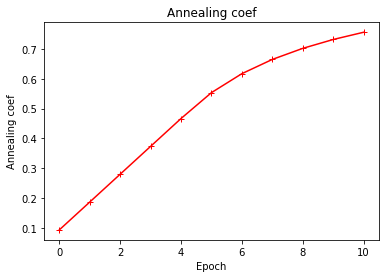

In [48]:
plt.figure(5)
plt.plot(history.history['annealing_coef'],c='r',marker='+')
plt.title('Annealing coef')
plt.xlabel('Epoch')
plt.ylabel('Annealing coef') 


Text(0, 0.5, 'Annealing step')

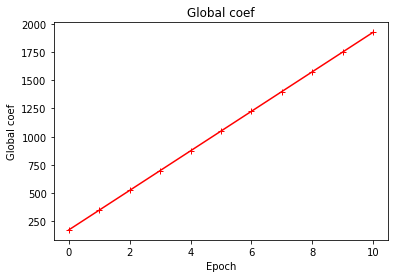

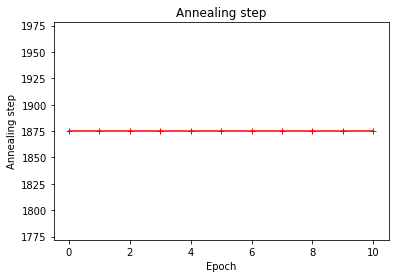

In [49]:
plt.figure(6)
plt.plot(history.history['global_step_get'],c='r',marker='+')
plt.title('Global coef')
plt.xlabel('Epoch')
plt.ylabel('Global coef') 

plt.figure(7)
plt.plot(history.history['annealing_step_get'],c='r',marker='+')
plt.title('Annealing step')
plt.xlabel('Epoch')
plt.ylabel('Annealing step') 

In [50]:
def draw_EDL_results(K, history):
    # train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f 
    # calculate uncertainty for training and testing data for correctly and misclassified samples
    '''
    K: known classes
    '''
    train_u_succ = K / (K+np.array(history['evidential_success']))
    train_u_fail = K / (K+np.array(history['evidential_fail']))
    test_u_succ  = K / (K+np.array(history['val_evidential_success']))
    test_u_fail  = K / (K+np.array(history['val_evidential_fail']))
    
    f, axs = plt.subplots(2, 2)
    f.set_size_inches([10,10])
    
    axs[0,0].plot(history['evidential_success'],c='r',marker='+')
    axs[0,0].plot(history['evidential_fail'],c='k',marker='x')
    axs[0,0].set_title('Train Data')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Estimated total evidence for classification') 
    axs[0,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[0,1].plot(train_u_succ,c='r',marker='+')
    axs[0,1].plot(train_u_fail,c='k',marker='x')
    axs[0,1].plot(history['acc'],c='blue',marker='*')
    axs[0,1].set_title('Train Data')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Estimated uncertainty for classification')
    axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    axs[1,0].plot(history['val_evidential_success'],c='r',marker='+')
    axs[1,0].plot(history['val_evidential_fail'],c='k',marker='x')
    axs[1,0].set_title('Test Data')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Estimated total evidence for classification') 
    axs[1,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[1,1].plot(test_u_succ,c='r',marker='+')
    axs[1,1].plot(test_u_fail,c='k',marker='x')
    axs[1,1].plot(history['val_acc'],c='blue',marker='*')
    axs[1,1].set_title('Test Data')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Estimated uncertainty for classification')
    axs[1,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    

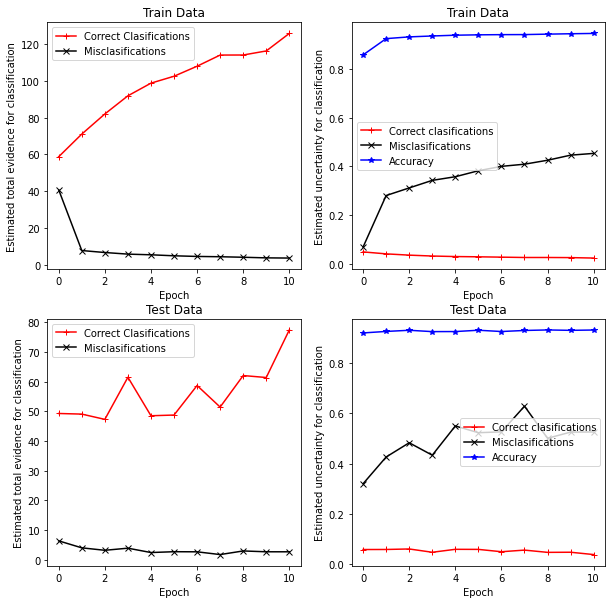

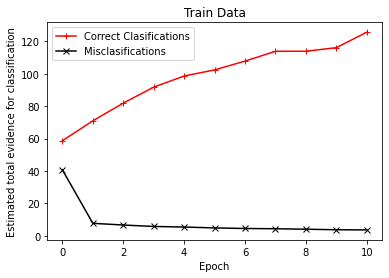

In [51]:
draw_EDL_results(class_n, history.history)

plt.figure(5)
plt.plot(history.history['evidential_success'],c='r',marker='+')
plt.plot(history.history['evidential_fail'],c='k',marker='x')
plt.title('Train Data')
plt.xlabel('Epoch')
plt.ylabel('Estimated total evidence for classification') 
plt.legend(['Correct Clasifications','Misclasifications'])


In [52]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from icecream import ic

def show_im(im, ax, title = "", vmin=None, vmax=None):
    im_plt = ax.imshow(im.astype(np.float32), vmin=vmin, vmax=vmax)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 



In [53]:
image_stack.shape

(17730, 9200, 21)

In [54]:
if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
    patchesHandler.dataset.image_channels[-1]

In [55]:
if type(dataset) == PAMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [56]:
image_stack.shape

(17730, 9200, 21)

In [57]:
#%% Test loop

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
# del image_stack
class_n = 3

-30.0 -16.0


In [58]:
save_probabilities

False

In [59]:

h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, inference_times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n), dtype = np.float32)

#    new_model = utils_v1.build_resunet(input_shape=(patch_size_rows,patch_size_cols, c), 
#        nb_filters = nb_filters, n_classes = class_n, dropout_seed = None)
    new_model = utils_v1.build_resunet(input_shape=(patch_size_rows,patch_size_cols, c), 
        nb_filters = nb_filters, n_classes = class_n, last_activation=None)

    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())
    
    patchesHandler.class_n = class_n

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,inference_times):
            print('time: ', tm)

            
            # Recinstructing predicted map
            start_test = time.time()
            '''
            args_network = {'patch_size_rows': patch_size_rows,
                'patch_size_cols': patch_size_cols,
                'c': c,
                'nb_filters': nb_filters,
                'class_n': class_n,
                'dropout_seed': inference_times}
            '''
            prob_reconstructed, u_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    # model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
                    # patch_size_cols, a = args_network)
                    
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec = prob_reconstructed.copy()
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp142/models/resunet_0.h5'


time:  0


In [60]:
prob_rec.shape


(17760, 9216)

In [61]:
'''
fig1 = plt.figure(figsize=(7,7))
plt.imshow(prob_rec[...,0], cmap = 'jet')
plt.axis('off')
'''

"\nfig1 = plt.figure(figsize=(7,7))\nplt.imshow(prob_rec[...,0], cmap = 'jet')\nplt.axis('off')\n"

In [62]:
'''
fig1 = plt.figure(figsize=(7,7))
plt.imshow(prob_rec[...,1], cmap = 'jet')
plt.axis('off')
'''

"\nfig1 = plt.figure(figsize=(7,7))\nplt.imshow(prob_rec[...,1], cmap = 'jet')\nplt.axis('off')\n"

In [63]:
'''
fig1 = plt.figure(figsize=(7,7))
plt.imshow(prob_rec[...,2], cmap = 'jet')
plt.axis('off')
'''

"\nfig1 = plt.figure(figsize=(7,7))\nplt.imshow(prob_rec[...,2], cmap = 'jet')\nplt.axis('off')\n"

In [64]:
u_reconstructed.shape
np.average(u_reconstructed)
# np.std(u_reconstructed)


0.06343031

In [65]:
'''
prob_rec2 = np.concatenate((prob_rec, np.expand_dims(u_reconstructed, axis=-1)), axis=-1)
prob_rec2.shape
'''

'\nprob_rec2 = np.concatenate((prob_rec, np.expand_dims(u_reconstructed, axis=-1)), axis=-1)\nprob_rec2.shape\n'

In [66]:
# np.unique(prob_rec2.argmax(axis=-1), return_counts=True)

In [67]:
'''
fig1 = plt.figure(figsize=(7,7))
plt.imshow(prob_rec2.argmax(axis=-1), cmap = 'jet')
plt.axis('off')
'''

"\nfig1 = plt.figure(figsize=(7,7))\nplt.imshow(prob_rec2.argmax(axis=-1), cmap = 'jet')\nplt.axis('off')\n"

(-0.5, 9215.5, 17759.5, -0.5)

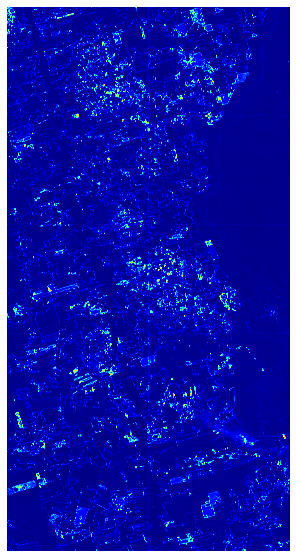

In [68]:

fig1 = plt.figure(figsize=(10,10))
plt.imshow(u_reconstructed, cmap = 'jet')
plt.axis('off')
# plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [69]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [70]:
del image1_pad


In [71]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, inference_times), dtype = np.float32)

    for tm in range(0, inference_times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)




In [72]:
useLessInferenceRuns = False
if useLessInferenceRuns == True:

    reducedInferenceRuns = 3
    # prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))


In [73]:
prob_rec.shape

(17760, 9216)

In [74]:
prob_rec.shape

(17760, 9216)

In [75]:
# mean_prob = np.mean(prob_rec, axis = -1)
mean_prob = prob_rec

# np.save(path_maps+'/prob_mean.npy', mean_prob)


In [76]:
ic(np.min(mean_prob), np.mean(mean_prob), np.max(mean_prob))

ic| np.min(mean_prob): 0.006728995
    np.mean(mean_prob): 0.030044498
    np.max(mean_prob): 0.94712526


(0.006728995, 0.030044498, 0.94712526)

In [77]:
ic(mean_prob.shape)

ic| mean_prob.shape: (17760, 9216)


(17760, 9216)

'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

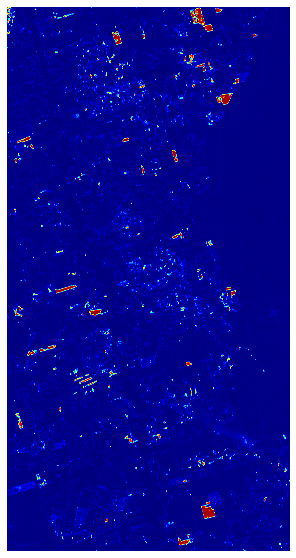

In [78]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


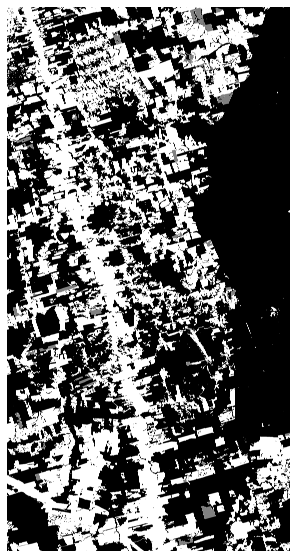

In [79]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [80]:
if issubclass(type(dataset), MultipleDates):
    label_mask = np.squeeze(label_mask)

In [81]:
mean_prob.shape

(17730, 9200)

(-0.5, 9199.5, 17729.5, -0.5)

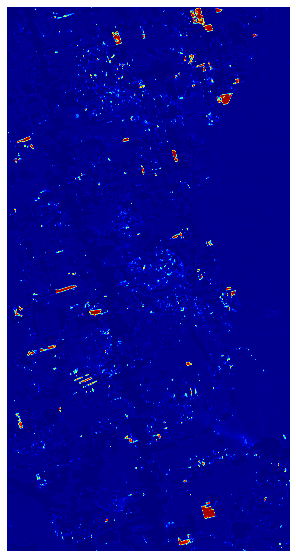

In [82]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
# plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [83]:
ic(np.mean(mean_prob), np.min(mean_prob), np.max(mean_prob))

ic| np.mean(mean_prob): 0.02277628
    np.min(mean_prob): 0.0
    np.max(mean_prob): 0.94712526


(0.02277628, 0.0, 0.94712526)

In [84]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(17730, 9200)


In [85]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [86]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

85.97


In [87]:
prob_rec.shape

(17760, 9216)

In [88]:
from icecream import ic

# ic(prob_rec.shape)
# prob_rec = np.transpose(prob_rec, (2, 0, 1))


In [89]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [90]:
ic(prob_rec.shape)

ic| prob_rec.shape: (17760, 9216, 1)


(17760, 9216, 1)

In [91]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 


In [92]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 0.006728995
    np.mean(prob_rec): 0.030044498
    np.max(prob_rec): 0.94712526
ic| prob_rec.shape: (17760, 9216, 1)


(17760, 9216, 1)

In [93]:

uncertainty_to_show = u_reconstructed.copy()[:label_mask.shape[0], :label_mask.shape[1]]

uncertainty_to_show[label_mask == 2] = 0


In [94]:
ic(np.min(uncertainty_to_show), np.mean(uncertainty_to_show), np.max(uncertainty_to_show))


ic| np.min(uncertainty_to_show): 0.0
    np.mean(uncertainty_to_show): 0.04395438
    np.max(uncertainty_to_show): 1.0


(0.0, 0.04395438, 1.0)

In [95]:
prob_rec.shape

(17760, 9216, 1)

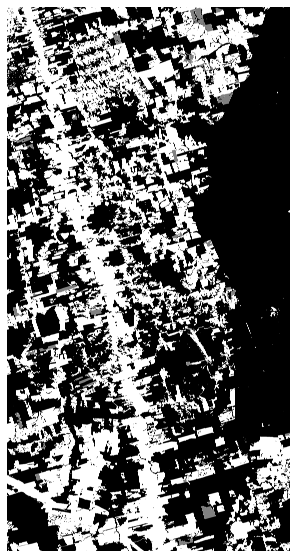

In [96]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

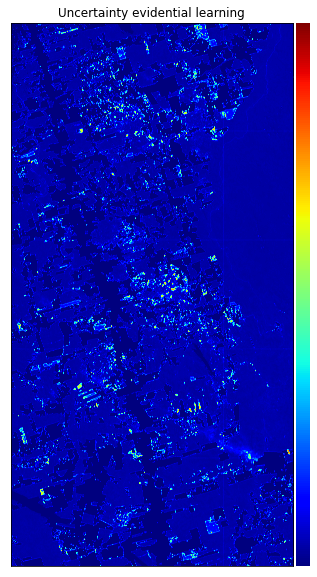

In [97]:


fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
show_im(uncertainty_to_show, ax, title = 'Uncertainty evidential learning')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty evidential learning.png', 
    dpi=150, bbox_inches='tight')

In [98]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (17760, 9216, 1)
ic| np.min(prob_rec): 0.006728995
    np.mean(prob_rec): 0.030044498
    np.max(prob_rec): 0.94712526


(0.006728995, 0.030044498, 0.94712526)

(array([0, 1, 2], dtype=uint8), array([81558000, 65246400, 16311600], dtype=int64))


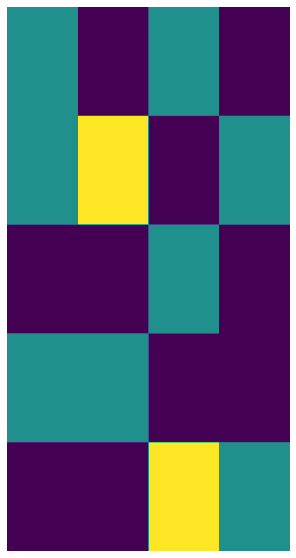

In [99]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [100]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [101]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  1838508, 161277492], dtype=int64))


(array([  0, 255], dtype=uint8), array([  1838508, 161277492], dtype=int64))

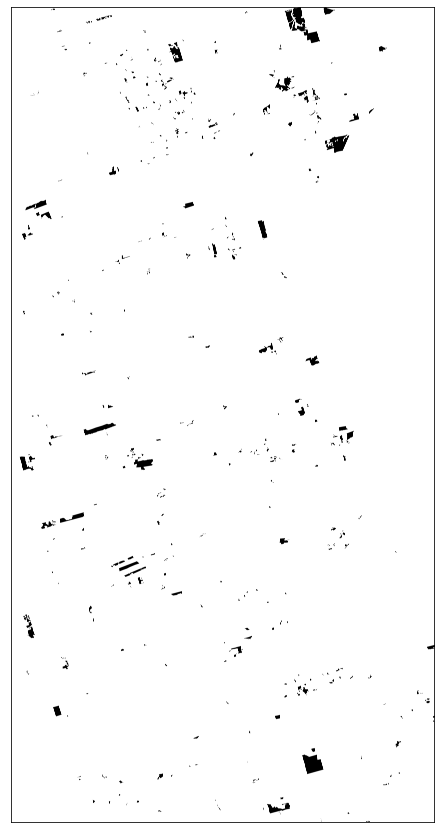

In [102]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [103]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (16311600,)
ic| label_mask_val_valid.shape: (9450701,)


(9450701,)

In [104]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [105]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.553046, F-Score=0.856


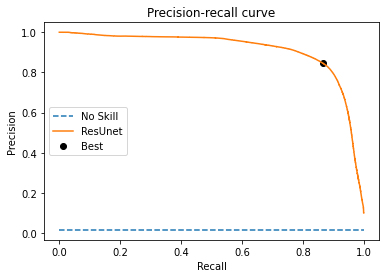

In [106]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [107]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
threshold = 0.5
# threshold = 0.698

predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0
# predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]>=threshold] = 1
# predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
predicted_unpad[label_mask == 2] = 0
ic(predicted_unpad.shape, predicted.shape)
del predicted

(17730, 9200)
(array([0., 1.], dtype=float32), array([161325825,   1790175], dtype=int64))


ic| predicted_unpad.shape: (17730, 9200)
    predicted.shape: (17730, 9200)


In [108]:
threshold

0.5

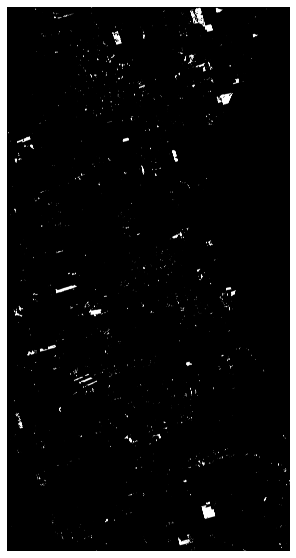

In [109]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [110]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [111]:
# mean_prob_unpad.shape

In [112]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [113]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [114]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [115]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [116]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask_current_deforestation.shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)
    mean_prob.shape: (17730, 9200)


((17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200))

In [117]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)


ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)


(54236371,)

In [118]:
importlib.reload(_metrics)
removePolygons = True
if removePolygons == True:
    # remove polygons smaller than 625 px
    min_polygon_area = 625 # pixels

    predicted_unpad, label_mask = _metrics.removeSmallPolygonsForMetrics(predicted_unpad, label_mask,
        min_polygon_area)
    predicted_masked, label_masked = _metrics.getTest(predicted_unpad, label_mask, mask_amazon_ts)

    predicted_test = predicted_masked
    label_mask_current_deforestation_test = label_masked


ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161325825,   1790175], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161575427,   1540573], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162866398,    249602], dtype=int64))
ic| predicted.shape: (17730, 9200), label_mask.shape: (17730, 9200)
ic| predicted_masked.shape: (81558000,)
    label_masked.shape: (81558000,)
ic| np.unique(label_masked, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                  array([53387146,   728676, 27442178], dtype=int64))
ic| predicted_masked.shape: (54115822,)
    label_masked.shape: (54115822,)


In [119]:

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        if removePolygons == False:
                mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                        mean_prob_test)*100, 2)
        else:
                '''
                # Computing metrics over the test tiles
                # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
                ref1 = np.ones_like(label_mask).astype(np.float32)

                ref1 [label_mask == 2] = 0
                TileMask = mask_amazon_ts * ref1
                GTTruePositives = label_mask==1

                # Metrics for th=0.5    

                Npoints = 50
                Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
                ProbList = np.linspace(Pmax,0,Npoints)

                metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 625)
                print('Metrics th = 0.5: ', metrics_*100)
                '''
                pass


In [120]:
ic(f1, precision, recall)
# ic(f1, precision, recall)


ic| f1: 82.85, precision: 89.97, recall: 76.77


(82.85, 89.97, 76.77)

### Metrics for validation set in forest/deforestation detection

In [121]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (17730, 9200)


(17730, 9200)

In [122]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [123]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 86.53
    precision_val: 88.53
    recall_val: 84.61
    mAP_val: 91.23


(86.53, 88.53, 84.61, 91.23)

In [124]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    # Computing metrics over the test tiles
    # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
    ref1 = np.ones_like(label_mask).astype(np.uint8)

    ref1 [label_mask == 2] = 0
    TileMask = mask_amazon_ts * ref1
    GTTruePositives = label_mask==1

    # Metrics for th=0.5    

    ProbList_05 = [0.5]

    metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
    print('Metrics th = 0.5: ', metrics_05*100)


In [125]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([162479731,    636269], dtype=int64))


In [126]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (17730, 9200)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   467102, 162479731,    169167], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   467102, 162479731,    169167], dtype=int64))

In [127]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

In [128]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

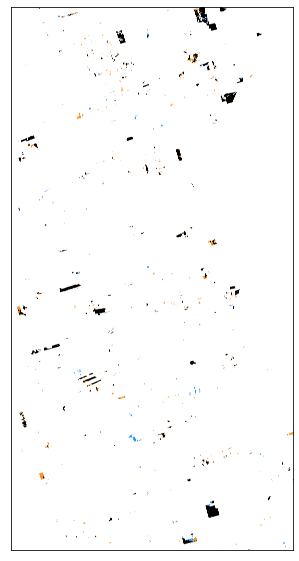

In [129]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


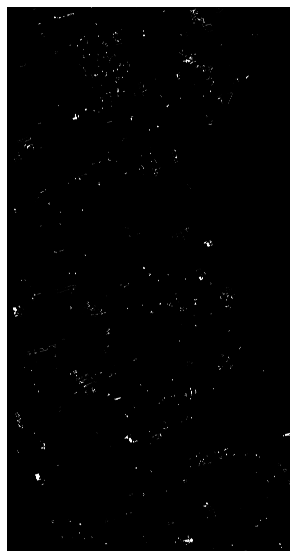

In [130]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [131]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (17730, 9200)
ic| mask_amazon_ts.shape: (17730, 9200)
ic| label_mask_test.shape: (81558000,)
ic| error_mask_test.shape: (54115822,)


(54115822,)

In [132]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [133]:
evidential_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(u_reconstructed, npad), mask_amazon_ts),
        label_mask_test)

In [134]:
evidential_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(u_reconstructed, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)


In [135]:
# dataset.previewLims1 = np.array([2200, 3200, 6900, 7900])
# dataset.previewLims2 = np.array([500, 1500, 3500, 4500])
# dataset.previewBands = [2, 1, 0] 

In [136]:

ic(dataset.previewLims1, dataset.previewLims2)
lims = dataset.previewLims1
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))
lims = dataset.previewLims2
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
ic(mask_amazon_ts.shape)


ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| mask_amazon_ts.shape: (17730, 9200)


(17730, 9200)

ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


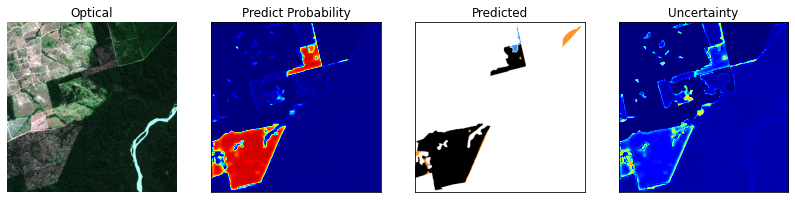

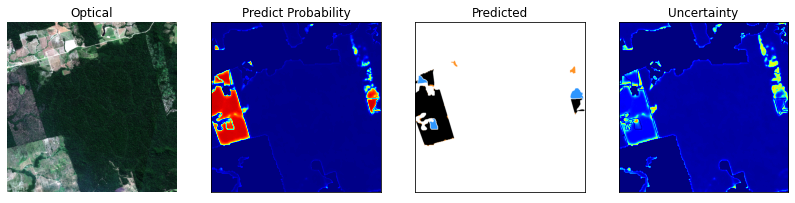

In [137]:


plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], uncertainty_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], uncertainty_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2.png', dpi=150, bbox_inches='tight')

In [138]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single evidential')
# predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.MI
# predictor = Predictor.KL
predictor = Predictor.evidential

# predictor = Predictor.pred_entropy_single

if predictor == Predictor.pred_var:
    uncertainty = pred_var_test
    uncertainty_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    uncertainty = MI_test
    uncertainty_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    uncertainty = pred_entropy_test
    uncertainty_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.KL:
    uncertainty = KL_test
    uncertainty_val = KL_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287

elif predictor == Predictor.pred_entropy_single:
    uncertainty = pred_entropy_single_test
    uncertainty_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287

elif predictor == Predictor.evidential:
    uncertainty = evidential_test
    uncertainty_val = evidential_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [139]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))
# ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(uncertainty): 0.025278548
    np.mean(uncertainty): 0.064334385
    np.max(uncertainty): 1.0


(0.025278548, 0.064334385, 1.0)

In [140]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, uncertainty.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, uncertainty, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, uncertainty_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (54115822,), uncertainty.shape: (54115822,)
ic| roc_auc: 0.9618182737540888


0.9618182737540888

Best Threshold=0.113297, G-Mean=0.918


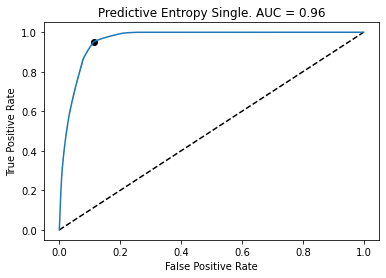

In [141]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [142]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.11329666


In [143]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [144]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(uncertainty)
y_pred_thresholded[uncertainty >= best_threshold_uncertainty] = 1


In [145]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [146]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [147]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [148]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [149]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [150]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [151]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [152]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, uncertainty_val, pos_label=pos_label)



In [153]:
ic(thresholds)

ic| thresholds: array([0.04595785, 0.04595786, 0.04595786, ..., 0.9993084 , 0.9993654 ,
                       1.        ], dtype=float32)


array([0.04595785, 0.04595786, 0.04595786, ..., 0.9993084 , 0.9993654 ,
       1.        ], dtype=float32)

In [154]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.566030, F-Score=0.238


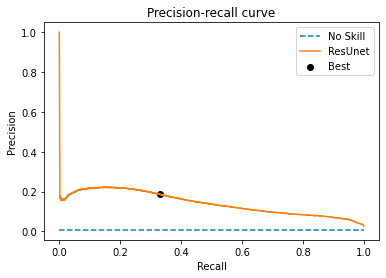

In [155]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [156]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [157]:
ic(np.min(uncertainty), np.average(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 0.025278548
    np.average(uncertainty): 0.064334385
    np.max(uncertainty): 1.0


(0.025278548, 0.064334385, 1.0)

In [158]:
# plt.hist(uncertainty)

In [159]:
ic(uncertainty.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| uncertainty.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [160]:
ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| uncertainty.shape: (54115822,)
    label_mask_current_deforestation_test.shape: (54115822,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [161]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 0.025278548
    np.mean(uncertainty): 0.064334385
    np.max(uncertainty): 1.0


(0.025278548, 0.064334385, 1.0)

In [162]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(uncertainty).astype(np.int8)
predicted_thresholded[uncertainty >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (54115822,)


(54115822,)

In [163]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([50610058,  3505764], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([100726308,   1766196,  60623496], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64))


((array([0, 1], dtype=uint8), array([50610058,  3505764], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([100726308,   1766196,  60623496], dtype=int64)),
 (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64)))

In [164]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.06478260646211749


0.06478260646211749

In [165]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(uncertainty, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.06478260646211749


0.06478260646211749

In [166]:
predictor

<Predictor.evidential: 6>

In [167]:

importlib.reload(_metrics)

# threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
if predictor == Predictor.pred_entropy:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.pred_var:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.13/0.36 for x in threshold_list] + [np.max(uncertainty)-0.0015, np.max(uncertainty)-0.0008]
elif predictor == Predictor.MI:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.235/0.36 for x in threshold_list] + [np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.KL:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*1.0/0.36 for x in threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
elif predictor == Predictor.evidential:
        # threshold_list = [0.015, 0.03, 0.04]
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [ 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [ 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

        # threshold_list = [ 0.15, 0.2,  
        #          0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

        # threshold_list = [0.015,0.1, 0.2, 0.27, 0.36, 0.45, 0.55, 0.65]

        # threshold_list = [x*1.0/0.36 for x in threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                
        # threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
print(threshold_list)
loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        # ic(metrics_values)


ic| uncertainty.shape: (54115822,)
    label_mask_current_deforestation_test.shape: (54115822,)


[0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
threshold 0.15
(50610058,) (50610058,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3505764,)
    predicted_test_classified_incorrect.shape: (3505764,)


cm_correct [[50331489      544]
 [   34285   243740]]


ic| TP_H + FN_H + FP_H + TN_H: 3505764
    len(label_mask_current_deforestation_test): 54115822
ic| TP_H + FN_H + FP_H + TN_H: 3505764
    len(label_mask_current_deforestation_test): 54115822


cm_incorrect [[2993320   61793]
 [ 135008  315643]]
[0.99777308 0.87668375 0.33449709 0.06478261 0.83628218 0.70041562]
threshold 0.2
(51327351,) (51327351,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2788471,)
    predicted_test_classified_incorrect.shape: (2788471,)


cm_correct [[50958287     4036]
 [   40707   324321]]


ic| TP_H + FN_H + FP_H + TN_H: 2788471
    len(label_mask_current_deforestation_test): 54115822
ic| TP_H + FN_H + FP_H + TN_H: 2788471
    len(label_mask_current_deforestation_test): 54115822


cm_incorrect [[2366522   58301]
 [ 128586  235062]]
[0.9877085  0.88848253 0.44508259 0.05152783 0.80126669 0.64639982]
threshold 0.225
(51579119,) (51579119,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2536703,)
    predicted_test_classified_incorrect.shape: (2536703,)


cm_correct [[51177890     5786]
 [   43336   352107]]


ic| TP_H + FN_H + FP_H + TN_H: 2536703
    len(label_mask_current_deforestation_test): 54115822
ic| TP_H + FN_H + FP_H + TN_H: 2536703
    len(label_mask_current_deforestation_test): 54115822


cm_incorrect [[2146919   56551]
 [ 125957  207276]]
[0.98383316 0.89041151 0.48321476 0.04687544 0.7856512  0.62201523]
threshold 0.25
(51791458,) (51791458,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2324364,)
    predicted_test_classified_incorrect.shape: (2324364,)


cm_correct [[51363383     7377]
 [   45661   375037]]


ic| TP_H + FN_H + FP_H + TN_H: 2324364
    len(label_mask_current_deforestation_test): 54115822
ic| TP_H + FN_H + FP_H + TN_H: 2324364
    len(label_mask_current_deforestation_test): 54115822


cm_incorrect [[1961426   54960]
 [ 123632  184346]]
[0.98070939 0.89146371 0.51468279 0.04295165 0.77033589 0.59856873]
threshold 0.27
(51943612,) (51943612,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2172210,)
    predicted_test_classified_incorrect.shape: (2172210,)


cm_correct [[51496324     8919]
 [   47314   391055]]


ic| TP_H + FN_H + FP_H + TN_H: 2172210
    len(label_mask_current_deforestation_test): 54115822
ic| TP_H + FN_H + FP_H + TN_H: 2172210
    len(label_mask_current_deforestation_test): 54115822


cm_incorrect [[1828485   53418]
 [ 121979  168328]]
[0.97770105 0.8920681  0.53666513 0.04014002 0.75910276 0.57982756]
threshold 0.3
(52150645,) (52150645,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1965177,)
    predicted_test_classified_incorrect.shape: (1965177,)


cm_correct [[51677560    11121]
 [   49674   412290]]


ic| TP_H + FN_H + FP_H + TN_H: 1965177
    len(label_mask_current_deforestation_test): 54115822
ic| TP_H + FN_H + FP_H + TN_H: 1965177
    len(label_mask_current_deforestation_test): 54115822


cm_incorrect [[1647249   51216]
 [ 119619  147093]]
[0.97373474 0.89247214 0.56580703 0.03631428 0.74173638 0.55150499]
threshold 0.34
(52399057,) (52399057,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1716765,)
    predicted_test_classified_incorrect.shape: (1716765,)


cm_correct [[51895131    14232]
 [   52534   437160]]


ic| TP_H + FN_H + FP_H + TN_H: 1716765
    len(label_mask_current_deforestation_test): 54115822
ic| TP_H + FN_H + FP_H + TN_H: 1716765
    len(label_mask_current_deforestation_test): 54115822


cm_incorrect [[1429678   48105]
 [ 116759  122223]]
[0.96847086 0.89272076 0.59993742 0.0317239  0.71757433 0.51143182]
threshold 0.36
(52516222,) (52516222,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1599600,)
    predicted_test_classified_incorrect.shape: (1599600,)


cm_correct [[51997582    16090]
 [   53921   448629]]


ic| TP_H + FN_H + FP_H + TN_H: 1599600
    len(label_mask_current_deforestation_test): 54115822
ic| TP_H + FN_H + FP_H + TN_H: 1599600
    len(label_mask_current_deforestation_test): 54115822


cm_incorrect [[1327227   46247]
 [ 115372  110754]]
[0.96537693 0.8927052  0.61567693 0.02955882 0.705435   0.48978888]
threshold 0.45
(53004076,) (53004076,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1111746,)
    predicted_test_classified_incorrect.shape: (1111746,)
ic| TP_H + FN_H + FP_H + TN_H: 1111746
    len(label_mask_current_deforestation_test): 54115822
ic| TP_H + FN_H + FP_H + TN_H: 1111746
    len(label_mask_current_deforestation_test): 54115822


cm_correct [[52424253    26842]
 [   61316   491665]]
cm_incorrect [[900556  35495]
 [107977  67718]]
[0.94823214 0.88911735 0.67473747 0.02054383 0.65609952 0.3854293 ]
threshold 0.55
(53456570,) (53456570,)


ic| label_current_deforestation_test_classified_incorrect.shape: (659252,)
    predicted_test_classified_incorrect.shape: (659252,)
ic| TP_H + FN_H + FP_H + TN_H: 659252
    len(label_mask_current_deforestation_test): 54115822
ic| TP_H + FN_H + FP_H + TN_H: 659252
    len(label_mask_current_deforestation_test): 54115822


cm_correct [[52810669    42431]
 [   78026   525444]]
cm_incorrect [[514140  19906]
 [ 91267  33939]]
[0.92528109 0.87070443 0.72109415 0.01218224 0.63030922 0.27106528]
threshold 0.65
(53833596,) (53833596,)


ic| label_current_deforestation_test_classified_incorrect.shape: (282226,)
    predicted_test_classified_incorrect.shape: (282226,)
ic| TP_H + FN_H + FP_H + TN_H: 282226
    len(label_mask_current_deforestation_test): 54115822
ic| TP_H + FN_H + FP_H + TN_H: 282226
    len(label_mask_current_deforestation_test): 54115822


cm_correct [[53111381    55856]
 [  116168   550191]]
cm_incorrect [[213428   6481]
 [ 53125   9192]]
[0.90783553 0.82566755 0.75505574 0.00521522 0.58648631 0.14750389]
threshold 0.8
(54086700,) (54086700,)


ic| label_current_deforestation_test_classified_incorrect.shape: (29122,)
    predicted_test_classified_incorrect.shape: (29122,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 29122
    len(label_mask_current_deforestation_test): 54115822
ic| TP_H + FN_H + FP_H + TN_H: 29122
    len(label_mask_current_deforestation_test): 54115822


cm_correct [[53301632    62337]
 [  163348   559383]]
cm_incorrect [[23177     0]
 [ 5945     0]]
[0.89973461 0.77398506 0.7676704  0.00053814        nan 0.        ]


In [168]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| uncertainty.shape: (54115822,)
    label_mask_current_deforestation_test.shape: (54115822,)


threshold 0.15
(54115822,) (54115822,)
cm_audited [[53386602      544]
 [   34285   694391]]
[0.99921719 0.95294891]
threshold 0.2
(54115822,) (54115822,)
cm_audited [[53383110     4036]
 [   40707   687969]]
[0.99416767 0.94413567]
threshold 0.225
(54115822,) (54115822,)
cm_audited [[53381360     5786]
 [   43336   685340]]
[0.99162815 0.94052775]
threshold 0.25
(54115822,) (54115822,)
cm_audited [[53379769     7377]
 [   45661   683015]]
[0.98931477 0.93733703]
threshold 0.27
(54115822,) (54115822,)
cm_audited [[53378227     8919]
 [   47314   681362]]
[0.98707918 0.93506854]
threshold 0.3
(54115822,) (54115822,)
cm_audited [[53376025    11121]
 [   49674   679002]]
[0.98388548 0.93182978]
threshold 0.34
(54115822,) (54115822,)
cm_audited [[53372914    14232]
 [   52534   676142]]
[0.97938509 0.92790486]
threshold 0.36
(54115822,) (54115822,)
cm_audited [[53371056    16090]
 [   53921   674755]]
[0.97670968 0.92600141]
threshold 0.45
(54115822,) (54115822,)
cm_audited [[53360304    2

ic| metric_values_audited: array([[0.99921719, 0.95294891],
                                  [0.99416767, 0.94413567],
                                  [0.99162815, 0.94052775],
                                  [0.98931477, 0.93733703],
                                  [0.98707918, 0.93506854],
                                  [0.98388548, 0.93182978],
                                  [0.97938509, 0.92790486],
                                  [0.97670968, 0.92600141],
                                  [0.96133402, 0.91585286],
                                  [0.93877916, 0.89292086],
                                  [0.91642877, 0.84057661],
                                  [0.90068428, 0.77582904]])


cm_audited [[53324809    62337]
 [  163348   565328]]
[0.90068428 0.77582904]


In [169]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [170]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(uncertainty,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(uncertainty,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [171]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [172]:
save_figures = True

In [173]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}

m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

In [174]:
m['f1_L']

array([0.93331725, 0.93547164, 0.93479404, 0.9339594 , 0.93292364,
       0.93133418, 0.92905431, 0.92761993, 0.91772376, 0.89716352,
       0.86480416, 0.83213594])

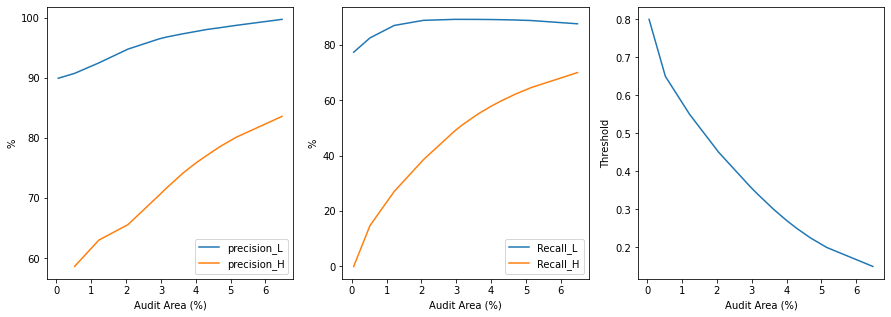

In [175]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [176]:
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]


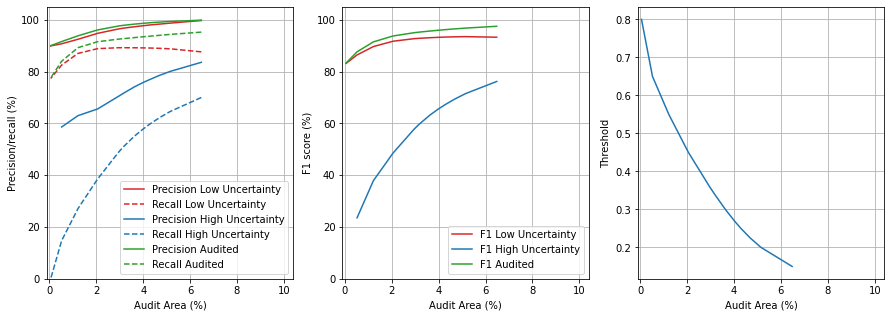

In [177]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()
ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.grid()
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [178]:


m

{'precision_L': array([0.99777308, 0.9877085 , 0.98383316, 0.98070939, 0.97770105,
        0.97373474, 0.96847086, 0.96537693, 0.94823214, 0.92528109,
        0.90783553, 0.89973461]),
 'recall_L': array([0.87668375, 0.88848253, 0.89041151, 0.89146371, 0.8920681 ,
        0.89247214, 0.89272076, 0.8927052 , 0.88911735, 0.87070443,
        0.82566755, 0.77398506]),
 'recall_Ltotal': array([0.33449709, 0.44508259, 0.48321476, 0.51468279, 0.53666513,
        0.56580703, 0.59993742, 0.61567693, 0.67473747, 0.72109415,
        0.75505574, 0.7676704 ]),
 'AA': array([0.06478261, 0.05152783, 0.04687544, 0.04295165, 0.04014002,
        0.03631428, 0.0317239 , 0.02955882, 0.02054383, 0.01218224,
        0.00521522, 0.00053814]),
 'precision_H': array([0.83628218, 0.80126669, 0.7856512 , 0.77033589, 0.75910276,
        0.74173638, 0.71757433, 0.705435  , 0.65609952, 0.63030922,
        0.58648631,        nan]),
 'recall_H': array([0.70041562, 0.64639982, 0.62201523, 0.59856873, 0.57982756,
     

In [179]:
m_audited

{'precision': array([0.99921719, 0.99416767, 0.99162815, 0.98931477, 0.98707918,
        0.98388548, 0.97938509, 0.97670968, 0.96133402, 0.93877916,
        0.91642877, 0.90068428]),
 'recall': array([0.95294891, 0.94413567, 0.94052775, 0.93733703, 0.93506854,
        0.93182978, 0.92790486, 0.92600141, 0.91585286, 0.89292086,
        0.84057661, 0.77582904]),
 'f1': array([0.97553475, 0.96850595, 0.96540222, 0.96262476, 0.96037019,
        0.95715038, 0.95295021, 0.95067984, 0.93804247, 0.91527596,
        0.87686537, 0.83360748])}

In [180]:
exp

142

In [181]:
threshold_list

[0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

In [182]:
# threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]


In [183]:
predictor

<Predictor.evidential: 6>

In [184]:

importlib.reload(_metrics)


if predictor == Predictor.evidential:
#        if exp == 90:
        threshold_list2 = [0.377] # 0.35, 0.4
        threshold_list2 = [0.5] # 0.35, 0.4
        threshold_list2 = [0.457] # 0.35, 0.4
        threshold_list2 = [0.56] # 0.35, 0.4

ic(uncertainty.shape, label_mask_current_deforestation_test.shape)

metrics_values2 = _metrics.getAA_Recall(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)

metric_values_audited2 = _metrics.getUncertaintyMetricsAudited(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)



ic| uncertainty.shape: (54115822,)
    label_mask_current_deforestation_test.shape: (54115822,)


threshold 0.56
(53497477,) (53497477,)


ic| label_current_deforestation_test_classified_incorrect.shape: (618345,)
    predicted_test_classified_incorrect.shape: (618345,)
ic| TP_H + FN_H + FP_H + TN_H: 618345
    len(label_mask_current_deforestation_test): 54115822
ic| TP_H + FN_H + FP_H + TN_H: 618345
    len(label_mask_current_deforestation_test): 54115822


cm_correct [[52844487    44147]
 [   80431   528412]]
cm_incorrect [[480322  18190]
 [ 88862  30971]]
[0.92289528 0.86789534 0.72516729 0.01142633 0.62999125 0.25845134]
threshold 0.56
(54115822,) (54115822,)
cm_audited [[53342999    44147]
 [   80431   648245]]
[0.93623988 0.88962035]


In [185]:
m2 = {'precision_L': metrics_values2[:,0],
        'recall_L': metrics_values2[:,1],
        'recall_Ltotal': metrics_values2[:,2],
        'AA': metrics_values2[:,3],
        'precision_H': metrics_values2[:,4],
        'recall_H': metrics_values2[:,5]}

m_audited2 = {'precision': metric_values_audited2[:,0],
        'recall': metric_values_audited2[:,1]}

m2['f1_L'] = 2*m2['precision_L']*m2['recall_L']/(m2['precision_L']+m2['recall_L'])
m2['f1_H'] = 2*m2['precision_H']*m2['recall_H']/(m2['precision_H']+m2['recall_H'])

m_audited2['f1'] = 2*m_audited2['precision']*m_audited2['recall']/(m_audited2['precision']+m_audited2['recall'])

ic(m2)
ic(m_audited2)


ic| m2: {'AA': array([0.01142633]),
         'f1_H': array([0.36653372]),
         'f1_L': array([0.89455071]),
         'precision_H': array([0.62999125]),
         'precision_L': array([0.92289528]),
         'recall_H': array([0.25845134]),
         'recall_L': array([0.86789534]),
         'recall_Ltotal': array([0.72516729])}
ic| m_audited2: {'f1': array([0.91233495]),
                 'precision': array([0.93623988]),
                 'recall': array([0.88962035])}


{'precision': array([0.93623988]),
 'recall': array([0.88962035]),
 'f1': array([0.91233495])}

(-0.5, 9199.5, 17729.5, -0.5)

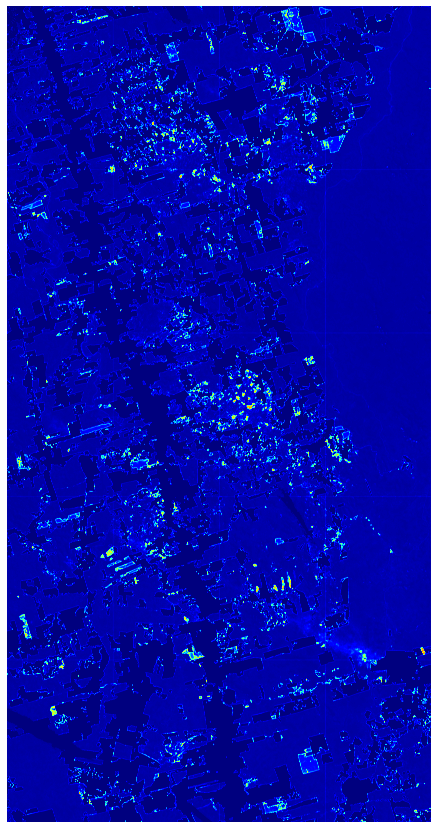

In [186]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_to_show, cmap='jet')
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

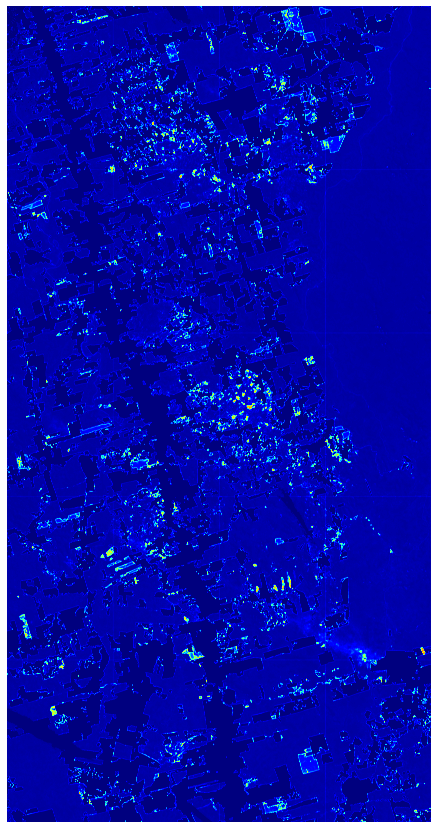

In [187]:

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_to_show, cmap='jet')
plt.axis('off')


In [188]:
# np.unique(label_mask_val_valid, return_counts=True)

In [189]:
'''
importlib.reload(_metrics)

threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list_val = [0.1]
        # y_test
        ic(uncertainty_val.shape, label_mask_val_valid.shape)
        importlib.reload(_metrics)

        metrics_values_val = _metrics.getAA_Recall(uncertainty_val, 
                label_mask_val_valid, 
                predicted_val, threshold_list_val)

        ic(metrics_values_val)
'''


'\nimportlib.reload(_metrics)\n\nthreshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]\n\nloadThresholdMetrics = False\nif loadThresholdMetrics == False:\n        # threshold_list_val = [0.1]\n        # y_test\n        ic(uncertainty_val.shape, label_mask_val_valid.shape)\n        importlib.reload(_metrics)\n\n        metrics_values_val = _metrics.getAA_Recall(uncertainty_val, \n                label_mask_val_valid, \n                predicted_val, threshold_list_val)\n\n        ic(metrics_values_val)\n'

In [190]:
'''
m_val = {'precision_L': metrics_values_val[:,0],
        'recall_L': metrics_values_val[:,1],
        'recall_Ltotal': metrics_values_val[:,2],
        'AA': metrics_values_val[:,3],
        'precision_H': metrics_values_val[:,4],
        'recall_H': metrics_values_val[:,5]}


save_figures=False
'''

"\nm_val = {'precision_L': metrics_values_val[:,0],\n        'recall_L': metrics_values_val[:,1],\n        'recall_Ltotal': metrics_values_val[:,2],\n        'AA': metrics_values_val[:,3],\n        'precision_H': metrics_values_val[:,4],\n        'recall_H': metrics_values_val[:,5]}\n\n\nsave_figures=False\n"

In [191]:
# threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


In [192]:
'''
plt.plot(m_val['precision_L']*100, m_val['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['precision_L']*100, m_val['AA']*100)\nplt.title('Precision vs. To-Audit Area')\nplt.xlabel('Precision (%)')\nplt.ylabel('Audit Area (%)')\nif True:\n    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')\n"

In [193]:
'''
plt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))\nplt.title('Precision vs. Threshold')\nplt.xlabel('Precision (%)')\nplt.ylabel('Threshold')\nif True:\n    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')\n"

In [194]:
'''
plt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)\nplt.title('Recall total vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif True:\n    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')\n"

In [195]:
'''
plt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))\nplt.title('Recall total vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif True:\n    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')\n"

In [196]:
'''
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, label="precision_L")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, m_val['recall_L']*100, label="Recall_L")
ax2.plot(m_val['AA']*100, m_val['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_L\']*100, label="precision_L")\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_H\']*100, label="precision_H")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'%\')\nax1.set_xlabel(\'Audit Area (%)\')\n\nax2.plot(m_val[\'AA\']*100, m_val[\'recall_L\']*100, label="Recall_L")\nax2.plot(m_val[\'AA\']*100, m_val[\'recall_H\']*100, label="Recall_H")\nax2.legend(loc="lower right")\nax2.set_ylabel(\'%\')\nax2.set_xlabel(\'Audit Area (%)\')\n\nax3.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), label="AA")\nax3.set_xlabel(\'Audit Area (%)\')\nax3.set_ylabel(\'Threshold\')\n\n# if save_figures == True:\nif True:\n    plt.savefig(\'figures/recall_precision_AA_val.png\', dpi=150, bbox_inches=\'tight\')\n'

In [197]:
'''
m_val['f1_L'] = 2*m_val['precision_L']*m_val['recall_L']/(m_val['precision_L']+m_val['recall_L'])
m_val['f1_H'] = 2*m_val['precision_H']*m_val['recall_H']/(m_val['precision_H']+m_val['recall_H'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['f1_L']*100, label="f1_L")
ax1.plot(m_val['AA']*100, m_val['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nm_val[\'f1_L\'] = 2*m_val[\'precision_L\']*m_val[\'recall_L\']/(m_val[\'precision_L\']+m_val[\'recall_L\'])\nm_val[\'f1_H\'] = 2*m_val[\'precision_H\']*m_val[\'recall_H\']/(m_val[\'precision_H\']+m_val[\'recall_H\'])\n\nfig, (ax1, ax2) = plt.subplots(1, 2)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'f1_L\']*100, label="f1_L")\nax1.plot(m_val[\'AA\']*100, m_val[\'f1_H\']*100, label="f1_H")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'%\')\nax1.set_xlabel(\'Audit Area (%)\')\n\nax2.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), label="AA")\nax2.set_xlabel(\'Audit Area (%)\')\nax2.set_ylabel(\'Threshold\')\n\n# if save_figures == True:\nif True:\n    plt.savefig(\'figures/f1_AA_val.png\', dpi=150, bbox_inches=\'tight\')\n'

In [198]:
'''
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.plot(m_val['AA']*100, m_val['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m_val['AA']*100, m_val['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_L\']*100, \'C0-\', label="Precision Low Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'recall_L\']*100, \'C0--\', label="Recall Low Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_H\']*100, \'C1-\', label="Precision High Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'recall_H\']*100, \'C1--\', label="Recall High Uncertainty")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'Precision/recall (%)\')\nax1.set_xlabel(\'Audit Area (%)\')\nax1.set_ylim(ylim)\nax1.set_xlim(xlim)\n\nax2.plot(m_val[\'AA\']*100, m_val[\'f1_L\']*100, label="F1 Low Uncertainty")\nax2.plot(m_val[\'AA\']*100, m_val[\'f1_H\']*100, label="F1 High Uncertainty")\nax2.legend(loc="lower right")\nax2.set_ylabel(\'F1 score (%)\')\nax2.set_xlabel(\'Audit Area (%)\')\nax2.set_ylim(ylim)\nax2.set_xlim(xlim)\n\nax3.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), lab